In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import natsort

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version =",tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf version = 2.2.0-dev20200416


## Import data

In [2]:
tpath = "ESOL/ESOL.csv"

data0 = pd.read_csv(tpath)
data0["Compound ID"].replace({"Atovaquone(0,430mg/ml) - neutral": "Atovaquone"}, inplace=True)
data0["Compound ID"].replace({"Etoposide (148-167,25mg/ml)": "Etoposide"}, inplace=True)
data0["Compound ID"].replace({"Sparsomycin (3,8mg/ml)": "Sparsomycin"}, inplace=True)
data0["Compound ID"].replace({"Digoxin (L1=41,8mg/mL, L2=68,2mg/mL, Z=40,1mg/mL)": "Digoxin"}, inplace=True)

data0.head()

data = data0.iloc[np.random.permutation(len(data0))] #randomly shuffles rows

data.head()

Compound ID  ESOL predicted log solubility in mols per litre  \
488  Coumatetralyl                                           -5.194   
963       difluron                                           -4.692   
833    Benfluralin                                           -5.205   
986     phenothrin                                           -6.763   
706         Furane                                           -1.837   

     Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
488               1           292.334                        1   
963               1           310.687                        2   
833               1           335.282                        0   
986               1           350.458                        0   
706               2            68.075                        0   

     Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
488                4                          1               50.44   
963                2                          2               58.20   
833                1                          7               89.52   
986                3                          6               35.53   
706                1                          0               13.14   

     measured log solubility in mols per litre  \
488                                      -2.84   
963                                      -6.02   
833                                      -5.53   
986                                      -5.24   
706                                      -0.82   

                                            smiles  
488           O=c2c(C3CCCc4ccccc43)c(O)c1ccccc1o2   
963           Fc1cccc(F)c1C(=O)NC(=O)Nc2ccc(Cl)cc2  
833    CCCCN(CC)c1c(cc(cc1N(=O)=O)C(F)(F)F)N(=O)=O  
986  CC(C)=CC3C(C(=O)OCc2cccc(Oc1ccccc1)c2)C3(C)C   
706                                        c1ccoc1

## Convert Smiles to Images
- Smile is converted into image(80x80 px) and saved as [iname].png in [path]
- while loop loops over all smiles in table

In [3]:
n = 0
n_max = data.shape[0]

while n < n_max:
    
    smi = data.iloc[n,9]

    size = (56,56)
    ipath = "ESOL_img/" + str(n) + ".png"

    mol = Chem.MolFromSmiles(smi)

    Draw.MolToImageFile(mol,ipath,size = size)
    
    n += 1


## Preprocess generated images

In [4]:
filename = natsort.natsorted(glob.glob("ESOL_img/*.png"))

img_list = [cv2.imread(file) for file in filename]


gimg_list = []
for img in img_list:
    gimg_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))    #list is converted to gray img's
    

for f in filename:      # delets images after converting them to array
    os.remove(f)

### Generate three arrays
- gimg_array = features
- Name = Compound ID
- comp_sol = log(sol) of compound

In [5]:
comp_sol = np.array(data["measured log solubility in mols per litre"].tolist())
gimg_array = (np.array(gimg_list)/255)
name = np.array(data["Compound ID"].tolist())


## Test if labels are linked in correct way

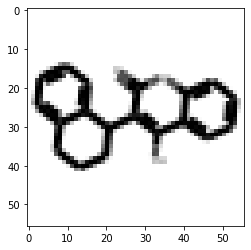

Coumatetralyl
-2.84


In [6]:
t = 0

plt.imshow(gimg_array[t], cmap = "gray")
plt.show()

print(name[t])
print(comp_sol[t])

## Generate training_data and test_data:

In [7]:
X_full = gimg_array.reshape(-1, size[0], size[1],1)
y_full = comp_sol

s = 0.8  #size in percent of training data from full data

train_size =round(len(X_full)*s)



X_train = X_full[:train_size]
y_train = y_full[:train_size]

X_test0 = X_full[train_size:]
y_test0 = y_full[train_size:]

X_test, X_val = X_test0[:len(X_test0)//2], X_test0[len(X_test0)//2:]
y_test, y_val = y_test0[:len(y_test0)//2], y_test0[len(y_test0)//2:]




print("X_train:",len(X_train),X_train.shape)
print("y_train:",len(y_train))
print("X_test:",len(X_test),X_test.shape)
print("y_test:",len(y_test))
print("X_val:",len(X_test),X_test.shape)
print("y_val:",len(y_test))


X_train: 902 (902, 56, 56, 1)
y_train: 902
X_test: 113 (113, 56, 56, 1)
y_test: 113
X_val: 113 (113, 56, 56, 1)
y_val: 113


## Augmentation of Dataset to compromise small size

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               401536    
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dropout_41 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 9         
Total params: 402,577
Trainable params: 402,577
Non-trainable params: 0
_______________________________________________

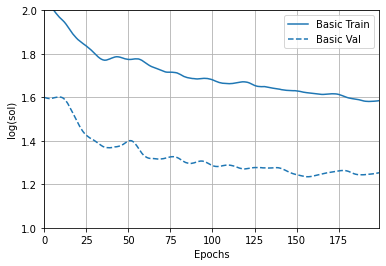

4/4 - 0s
Testing set Mean Abs Error: +/-  1.28 mol/l


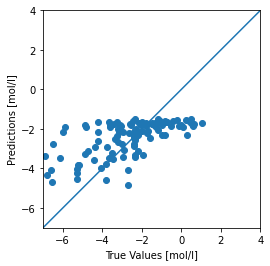

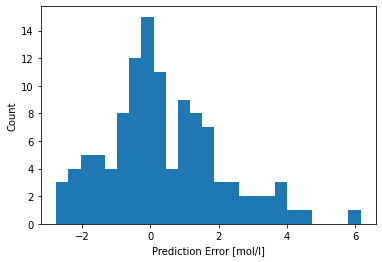

In [29]:
batch_size = 16
epochs = 200
lr = 0.0001

def build_model():
  model = keras.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1:])),
    layers.Dense(128, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
  ])
  
  

  optimizer = tf.keras.optimizers.Adam(lr)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


model = build_model()

print(model.summary())


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=15,       
)


# this is the augmentation configuration we will use for testing:
# nothing
test_datagen = ImageDataGenerator()

#indefinitely generates
# batches of augmented image data
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow(X_val, y_val, batch_size = batch_size)


history = model.fit(
        train_generator,
        steps_per_epoch= len(X_train) // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = len(X_val) // batch_size,
        verbose = 0, callbacks=[tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([1, 2])
plt.ylabel('log(sol)')
plt.show()

loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: +/- {:5.2f} mol/l".format(mae))

test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mol/l]')
plt.ylabel('Predictions [mol/l]')
lims = [-7, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mol/l]")
_ = plt.ylabel("Count")

plt.show()